In [40]:
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
def get_bs_df(code, list_para, start_date, end_date, frequency='d', adjustflag='3'):
    para = ','.join(list_para)
    rs = bs.query_history_k_data_plus(code,para,
    start_date=start_date, end_date=end_date,
    frequency=frequency, adjustflag=adjustflag)
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    df_result = pd.DataFrame(data_list, columns=rs.fields)
    print(f'get {len(df_result)} records!')
    return df_result
    

In [15]:
def get_bs_profit_data(code, year, quarter):
    profit_list = []
    rs_profit = bs.query_profit_data(code=code, year=year, quarter=quarter)
    while (rs_profit.error_code == '0') & rs_profit.next():
        profit_list.append(rs_profit.get_row_data())
    df_result = pd.DataFrame(profit_list, columns=rs_profit.fields)
    return df_result

In [8]:
lg = bs.login()

login success!


In [33]:
code = 'sh.600000'
list_para = ['date', 'code', 'close', 'volume', 'turn', 'peTTM', 'psTTM']
start_date = '2020-01-01'
end_date = '2024-01-20'

In [34]:
df_daily = get_bs_df(code, list_para, start_date, end_date)
df_profit = get_bs_profit_data(code, '2020', '1')

get 984 records!


In [35]:
df_profit

,code,pubDate,statDate,roeAvg,npMargin,gpMargin,netProfit,epsTTM,MBRevenue,totalShare,liqaShare
0,sh.600000,2020-04-25,2020-03-31,0.030746,0.316289,,17530000000.000000,2.037777,,29352080397.00,28103763899.00


In [50]:
# get market value and earning
df_daily['market_value'] = df_daily['close'].astype(float) * float(df_profit['liqaShare'].iloc[0])
df_daily['peTTM'] = df_daily['peTTM'].replace('', pd.NaT)
df_daily['peTTM'] = df_daily['peTTM'].astype(float)
df_daily['peTTM'] = df_daily['peTTM'].fillna((df_daily['peTTM'].shift() + df_daily['peTTM'].shift(-1)) / 2)
df_daily['earning'] = df_daily['market_value'] / df_daily['peTTM'].astype(float)
df_daily

,date,code,close,volume,turn,peTTM,psTTM,market_value,earning
0,2020-01-02,sh.600000,12.4700,51629079,0.183700,5.994733,1.915555,3.504539e+11,5.846031e+10
1,2020-01-03,sh.600000,12.6000,38018810,0.135300,6.057229,1.935525,3.541074e+11,5.846030e+10
2,2020-01-06,sh.600000,12.4600,41001193,0.145900,5.989926,1.914019,3.501729e+11,5.846030e+10
3,2020-01-07,sh.600000,12.5000,28421482,0.101100,6.009155,1.920164,3.512970e+11,5.846031e+10
4,2020-01-08,sh.600000,12.3200,35240536,0.125400,5.922624,1.892513,3.462384e+11,5.846030e+10
...,...,...,...,...,...,...,...,...,...
979,2024-01-15,sh.600000,6.5100,28694155,0.097800,4.938175,1.074966,1.829555e+11,3.704921e+10
980,2024-01-16,sh.600000,6.5900,53186496,0.181200,4.998859,1.088176,1.852038e+11,3.704922e+10
981,2024-01-17,sh.600000,6.5300,48249869,0.164400,4.953346,1.078268,1.835176e+11,3.704921e+10
982,2024-01-18,sh.600000,6.5600,73994422,0.252100,4.976102,1.083222,1.843607e+11,3.704922e+10


<Axes: >

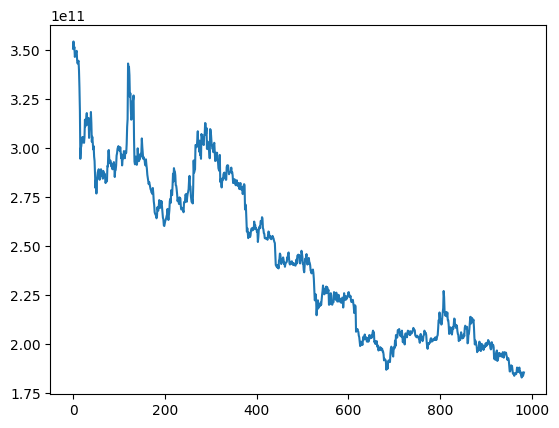

In [51]:
df_daily['market_value'].plot()

<Axes: >

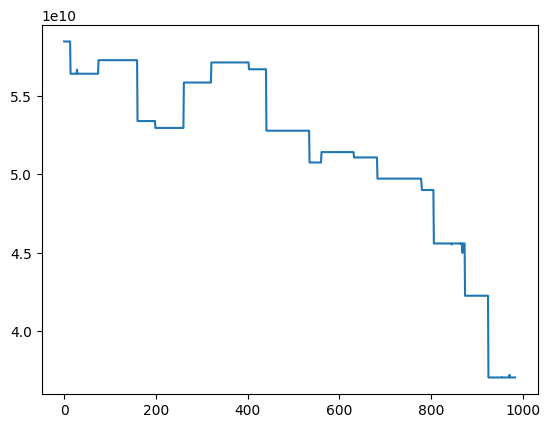

In [52]:
df_daily['earning'].plot()

### neutralize the market value

In [53]:
groups = df_daily.groupby('date')
groups

In [58]:
# 定义一个函数来执行市值中性化
def market_neutralize(group):
    # 提取市值和收益的数据列
    market_cap = group['market_value']
    returns = group['earning']
    # 添加截距项
    X = sm.add_constant(market_cap)
    # 执行线性回归，拟合收益率与市值的关系
    model = sm.OLS(returns, X)
    results = model.fit()
    # 提取回归系数
    beta = results.params['market_value']
    # 计算市值中性化后的收益
    neutralized_returns = returns - beta * market_cap
    # 将市值中性化后的收益添加到数据框中
    group['neutralized_value'] = neutralized_returns
    return group

In [59]:
neutralized_data = groups.apply(market_neutralize)

C:\Users\livid\AppData\Local\Temp\ipykernel_26144\1156377993.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neutralized_data = groups.apply(market_neutralize)


In [60]:
neutralized_data

,,date,code,close,volume,turn,peTTM,psTTM,market_value,earning,neutralized_value
date,,,,,,,,,,,
2020-01-02,0,2020-01-02,sh.600000,12.4700,51629079,0.183700,5.994733,1.915555,3.504539e+11,5.846031e+10,-0.000008
2020-01-03,1,2020-01-03,sh.600000,12.6000,38018810,0.135300,6.057229,1.935525,3.541074e+11,5.846030e+10,-0.000008
2020-01-06,2,2020-01-06,sh.600000,12.4600,41001193,0.145900,5.989926,1.914019,3.501729e+11,5.846030e+10,0.000000
2020-01-07,3,2020-01-07,sh.600000,12.5000,28421482,0.101100,6.009155,1.920164,3.512970e+11,5.846031e+10,0.000000
2020-01-08,4,2020-01-08,sh.600000,12.3200,35240536,0.125400,5.922624,1.892513,3.462384e+11,5.846030e+10,-0.000008
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,979,2024-01-15,sh.600000,6.5100,28694155,0.097800,4.938175,1.074966,1.829555e+11,3.704921e+10,0.000000
2024-01-16,980,2024-01-16,sh.600000,6.5900,53186496,0.181200,4.998859,1.088176,1.852038e+11,3.704922e+10,0.000000
2024-01-17,981,2024-01-17,sh.600000,6.5300,48249869,0.164400,4.953346,1.078268,1.835176e+11,3.704921e+10,0.000000


<Axes: xlabel='date,None'>

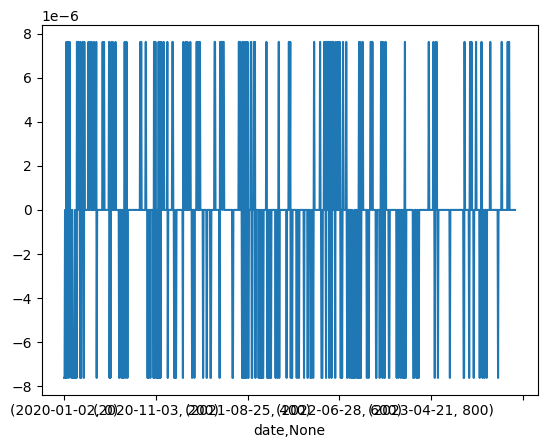

In [61]:
neutralized_data['neutralized_value'].plot()

In [71]:
def get_all_stock(day):
    rs = bs.query_all_stock(day=day)
    print('login respond  error_msg:'+lg.error_msg)
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    df_result = pd.DataFrame(data_list, columns=rs.fields)
    return df_result

In [74]:
df_all_stock = get_all_stock('2023-06-30')
df_all_stock

login respond  error_msg:success


,code,tradeStatus,code_name
0,bj.430017,1,
1,bj.430047,1,
2,bj.430090,1,
3,bj.430139,1,
4,bj.430198,1,
...,...,...,...
5729,sz.399994,1,中证信息安全主题指数
5730,sz.399995,1,中证基建工程指数
5731,sz.399996,1,中证智能家居指数
5732,sz.399997,1,中证白酒指数


In [75]:
df_all_stock

,code,tradeStatus,code_name
0,bj.430017,1,
1,bj.430047,1,
2,bj.430090,1,
3,bj.430139,1,
4,bj.430198,1,
...,...,...,...
5729,sz.399994,1,中证信息安全主题指数
5730,sz.399995,1,中证基建工程指数
5731,sz.399996,1,中证智能家居指数
5732,sz.399997,1,中证白酒指数


In [79]:
random_code_list = df_all_stock['code'].sample(n=100, random_state=42)
random_code_list[:10]

4200    sz.300042
4523    sz.300382
5039    sz.300915
5271    sz.301176
4570    sz.300429
80      bj.833533
4793    sz.300657
5444    sz.399001
2275    sh.688195
4889    sz.300759
Name: code, dtype: object

In [92]:
df_random_stock = pd.DataFrame()
for code in random_code_list:
    df_query_profit = get_bs_profit_data(code, '2023', '1')
    df_random_stock = pd.concat([df_query_profit, df_random_stock])
df_random_stock

,code,pubDate,statDate,roeAvg,npMargin,gpMargin,netProfit,epsTTM,MBRevenue,totalShare,liqaShare
0,sz.002218,2023-04-29,2023-03-31,0.002858,0.050926,0.289261,12106116.880000,0.069248,,1413020549.00,1387097895.00
0,sz.301357,2023-04-27,2023-03-31,0.044201,0.354312,0.651019,17763133.330000,1.471854,,51000000.00,
0,sz.300499,2023-04-26,2023-03-31,-0.003956,-0.037230,0.227312,-5611060.330000,0.883847,,308620124.00,271911172.00
0,sh.688269,2023-04-28,2023-03-31,0.041665,0.083434,0.147126,41259946.580000,1.582064,,130704000.00,60475900.00
0,sz.301279,2023-04-26,2023-03-31,0.007763,0.069013,0.141962,10281710.320000,0.773333,,100000000.00,23466231.00
...,...,...,...,...,...,...,...,...,...,...,...
0,sz.300429,2023-04-28,2023-03-31,-0.000570,-0.012060,0.258751,-2244763.150000,-0.230454,,515261048.00,375715354.00
0,sz.301176,2023-04-27,2023-03-31,-0.001667,-0.009401,0.049233,-2776984.670000,0.202462,,169066667.00,41056040.00
0,sz.300915,2023-04-26,2023-03-31,0.016050,0.097880,0.343378,23510745.420000,0.940146,,90000000.00,24817500.00
0,sz.300382,2023-04-27,2023-03-31,0.015834,0.107267,0.363690,31710249.410000,0.351077,,626551245.00,626494545.00


In [93]:
for col in ['roeAvg', 'npMargin', 'gpMargin', 'epsTTM']:
    df_random_stock[col] = df_random_stock[col].replace('', float('nan'))
    df_random_stock[col] = df_random_stock[col].astype(float)
    df_random_stock[col] = df_random_stock[col].fillna((df_random_stock[col].shift() + df_random_stock[col].shift(-1)) / 2)
    df_random_stock[col] = df_random_stock[col].ffill().bfill()

In [94]:
df_random_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, 0 to 0
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   code        82 non-null     object 
 1   pubDate     82 non-null     object 
 2   statDate    82 non-null     object 
 3   roeAvg      82 non-null     float64
 4   npMargin    82 non-null     float64
 5   gpMargin    82 non-null     float64
 6   netProfit   82 non-null     object 
 7   epsTTM      82 non-null     float64
 8   MBRevenue   82 non-null     object 
 9   totalShare  82 non-null     object 
 10  liqaShare   82 non-null     object 
dtypes: float64(4), object(7)
memory usage: 7.7+ KB


In [101]:
X_test

,roeAvg,npMargin,gpMargin
0,0.016232,0.046711,0.133795
0,0.002858,0.050926,0.289261
0,-0.001427,-0.014075,0.426115
0,0.003687,0.051831,0.379887
0,-0.001023,-0.017475,0.372661
0,0.014409,0.034625,0.160729
0,0.010022,0.154165,0.383633
0,0.015091,0.102811,0.298783
0,0.007763,0.069013,0.141962
0,0.002516,0.015641,0.132594


In [102]:
X = df_random_stock[['roeAvg', 'npMargin', 'gpMargin']] # 特征因子
y = df_random_stock['epsTTM'] # 目标变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = pd.DataFrame(scaler.transform(X_test))
model = LinearRegression()
model.fit(X_train, y_train)
print('Factor weights:', model.coef_)
y_pred = model.predict(X_test)
predicted_returns = pd.DataFrame({
    'Stock': X_test.index,
    'Predicted return': y_pred
})
selected_stocks = predicted_returns[predicted_returns['Predicted return'] > 0.1]
print('Selected stocks:', selected_stocks)

Factor weights: [0.5816784  0.2429101  0.27459906]
Selected stocks:     Stock  Predicted return
0       0          0.550256
1       1          0.391729
2       2          0.451719
3       3          0.537539
4       4          0.390086
5       5          0.535062
6       6          0.728756
7       7          0.748340
8       8          0.329657
9       9          0.166179
10     10          0.868106
11     11          0.664897
12     12          1.249381
13     13          1.205148
14     14          0.881246
15     15          1.089587
16     16          0.447703


In [104]:
y_pred

array([0.55025615, 0.39172872, 0.45171871, 0.5375395 , 0.39008628,
       0.5350618 , 0.72875629, 0.74833969, 0.32965658, 0.16617911,
       0.86810565, 0.66489708, 1.24938099, 1.20514782, 0.88124623,
       1.08958659, 0.44770297])

In [109]:
pd.Series(y_test)

0    0.209028
0    0.069248
0    1.690382
0    0.278836
0    0.010221
0    0.438135
0    0.462125
0    0.789891
0    0.773333
0    0.053418
0   -0.210894
0    0.056950
0    2.125819
0    5.535384
0    0.398913
0    0.309732
0    0.421868
Name: epsTTM, dtype: float64

In [117]:
pd.DataFrame({'y_pred':y_pred, 'y_test':y_test, 'diff %':(y_pred-y_test)/y_test*100})

,y_pred,y_test,diff %
0,0.550256,0.209028,163.245189
0,0.391729,0.069248,465.689574
0,0.451719,1.690382,-73.277123
0,0.537539,0.278836,92.779805
0,0.390086,0.010221,3716.517772
0,0.535062,0.438135,22.122587
0,0.728756,0.462125,57.696791
0,0.748340,0.789891,-5.260385
0,0.329657,0.773333,-57.371976
0,0.166179,0.053418,211.091981


**ps** 看得出线性回归这样预测的效果并不理想